# Forecasting timeseries AutoGluon AutoML

predictor = TimeSeriesPredictor().fit(
   train_data,
   hyperparameters={
      "DeepAR": {},
      "ETS": {},
   },
)

https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html

For example: 

ETS    = Exponential smoothing with trend and seasonality.

DeepAR = Autoregressive forecasting model based on a recurrent neural network 

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 67.7 MB/s eta 0:00:00:00:0100:01


## Zero-shot forecasting

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

## example 1: load data as a ECG timeseries

In [ ]:
#data_path = 'https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv'
#data_path = 'https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format.csv'

#data = TimeSeriesDataFrame.from_path(
##    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
#      "https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format.csv"  
#)

#data.head()

## UsdRubTime-AG-TS-format has a 5 period. See column "item_id" - number of item_id is a one of a period.

Next, we create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"bolt_small"` presets to use the Chronos-Bolt (Small, 48M) model in zero-shot mode.

In [30]:
data_path = '/kaggle/input/ecg-timeseries-for-prediction/ecg_1d_timeseries_prediction.csv'
#data_path = "https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format.csv"  
#data_path = 'https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format.csv'
data = pd.read_csv(data_path, delimiter=';')
#data['item_id']=1
data = data.rename(columns={"time":"timestamp"})
#data = data.rename(columns={"ecg_value":"target"})

#data['timestamp'] = data['timestamp']*1e2
data['timestamp'] = pd.to_datetime(data['timestamp'],unit='m')
#data['timestamp'] = pd.to_timedelta(data['timestamp']*1e2)
#data['timestamp'] = pd.to_datetime(data.timestamp, unit="h").dt.time

data = data.rename(columns = {'ecg_value':'target'})

data.head(5)
#print(len(data))

,timestamp,target
0,1970-01-01 00:00:00.000,496
1,1970-01-01 00:00:00.060,496
2,1970-01-01 00:00:00.120,497
3,1970-01-01 00:00:00.180,498
4,1970-01-01 00:00:00.240,498


## example 2: let's make a simple signal

In [ ]:
# syntetic signal
t = np.linspace(0,20,100)
y = np.sin(t)+np.cos(4*t)
plt.plot(t,y)
data = pd.DataFrame(t, columns = ["timestamp"])
data['timestamp'] = pd.to_datetime(data['timestamp'],unit='m')
data["target"]=pd.DataFrame(y)
data.head()

## Signal Visualization

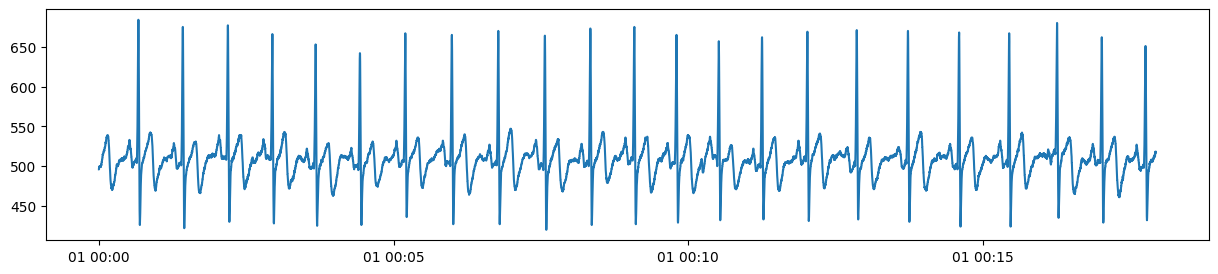

In [31]:
plt.rcParams["figure.figsize"] = (15,3)

plt.plot(data['timestamp'],data['target'])

In [32]:
# so, we need to make a regular timeseries from data-array
# AutoGluon works with a special array format 
# It must have a "timestamp" column and it must be regularized as a 1 or 3 sec

data.set_index('timestamp', inplace=True)

data = data.resample('1s').mean()
#data = data.resample('3s').mean()
data.head()

,target
timestamp,
1970-01-01 00:00:00,498.529412
1970-01-01 00:00:01,499.176471
1970-01-01 00:00:02,502.937500
1970-01-01 00:00:03,510.294118
1970-01-01 00:00:04,516.647059


In [33]:
#next step - we must add "item_id" column - it's needed for Chronos
data['item_id']=1
data = data.reset_index()
data.reindex(['item_id'])
data.set_index('item_id', inplace=False)
data.head()

,timestamp,target,item_id
0,1970-01-01 00:00:00,498.529412,1
1,1970-01-01 00:00:01,499.176471,1
2,1970-01-01 00:00:02,502.937500,1
3,1970-01-01 00:00:03,510.294118,1
4,1970-01-01 00:00:04,516.647059,1


# We need transform DataFrame for Special AutoGluon format

In [34]:
data_tsdf = TimeSeriesDataFrame.from_data_frame(data)
data_tsdf = data_tsdf.convert_frequency(freq = "s")
#data = data.convert_frequency(freq = "s")
#https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
data_tsdf = data_tsdf.fill_missing_values(method = 'interpolate')
print('Size the dataframe is', len(data_tsdf))
data_tsdf.head()

Size the dataframe is 1077


target
item_id timestamp                      
1       1970-01-01 00:00:00  498.529412
        1970-01-01 00:00:01  499.176471
        1970-01-01 00:00:02  502.937500
        1970-01-01 00:00:03  510.294118
        1970-01-01 00:00:04  516.647059

In [35]:
prediction_length = round((len(data_tsdf)/10))
prediction_length

108

Forecasting length 108


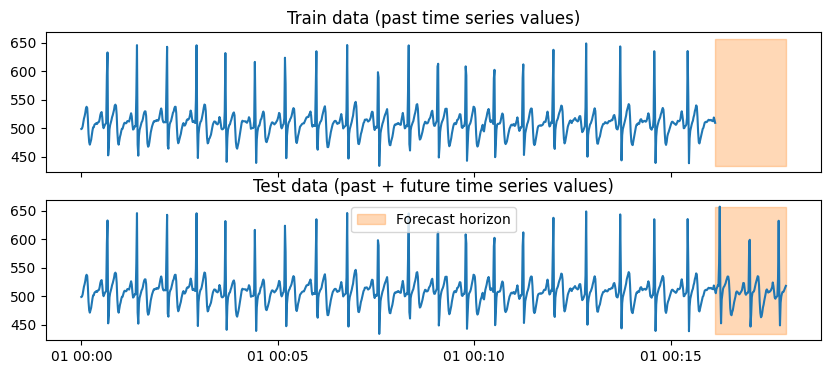

In [36]:
# let's predict 10% of total timeseries lenght 
prediction_length = round((len(data_tsdf)/10))
print('Forecasting length', prediction_length)

train_data, test_data = data_tsdf.train_test_split(prediction_length)

item_id = 1
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data.loc[item_id]
test_ts = test_data.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

1077

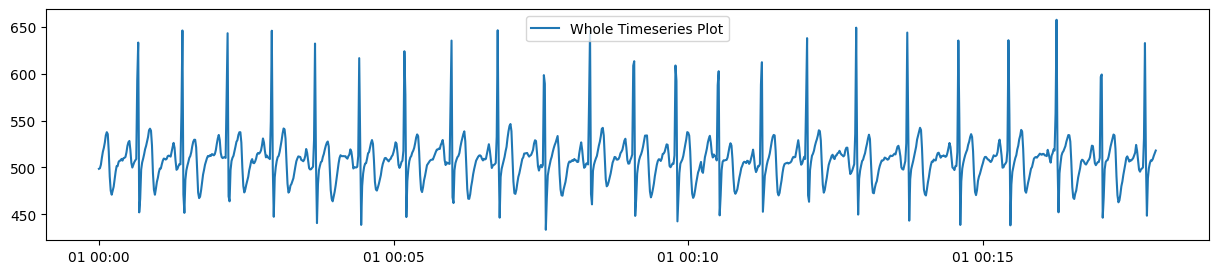

In [37]:
data_ts = data_tsdf.loc[item_id]
plt.plot(data_ts, label='Whole Timeseries Plot')
plt.legend()
len(data_ts)

In [38]:
print('Lenght =',len(test_ts),'\n',
      'train size =', len(train_ts), '\n',
      'test size', len(test_ts)-len(train_ts))

Lenght = 1077 
 train size = 969 
 test size 108


In [39]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
   train_data,
   verbosity=0,
   hyperparameters={
      "AutoARIMA": {},
   },
)
predictions = predictor.predict(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20250402_064827"


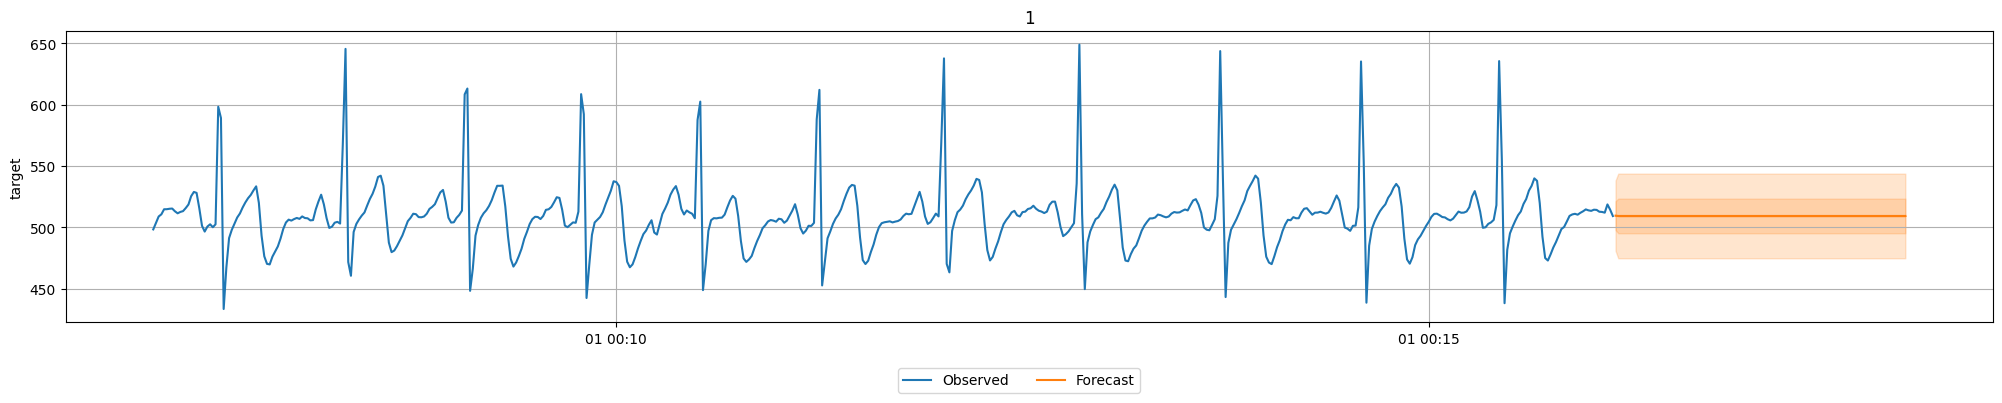

In [40]:
predictor.plot(
    data=train_data,
    quantile_levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
    predictions=predictions,
    item_ids=data_tsdf.item_ids[:1],
    max_history_length=prediction_length*5,
);

108


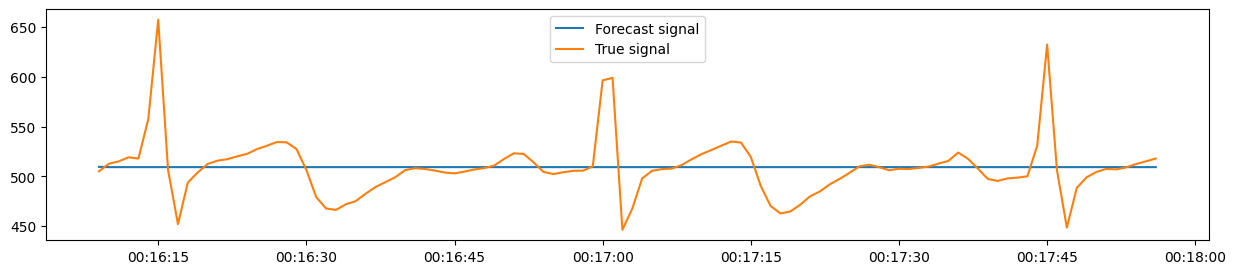

In [41]:
forecast_ts = predictions.loc[item_id]['mean']
print(len(forecast_ts))
plt.plot(forecast_ts, label="Forecast signal")
plt.plot(test_ts.tail(prediction_length), label="True signal")
plt.legend()

# Forecast of Chronos from Autogluon


AutoGluon-TimeSeries (AG-TS) includes [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API. This tutorial describes how to
- Use Chronos models in **zero-shot** mode to make forecasts without any dataset-specific training
- **Fine-tune** Chronos models on custom data to improve the accuracy
- Handle **covariates & static features** by combining Chronos with a tabular regression model
  
## Getting started with Chronos from AutoGluon

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS (Autogluon timeseries)
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference.

More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

In [ ]:
predictor = TimeSeriesPredictor(freq="s",
                                prediction_length=prediction_length, 
                                eval_metric="MASE").fit(train_data,
                                                        verbosity=0,
                                                        presets="bolt_base",
                                                        num_val_windows=30)
#predictor.evaluate(test_data)

predictions = predictor.predict(train_data)

In [ ]:
predictor.plot(
    data=train_data,
    quantile_levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
    predictions=predictions,
    item_ids=data_tsdf.item_ids[:1],
    max_history_length=prediction_length*5,
);

In [ ]:
forecast_ts = predictions.loc[item_id]['mean']
print(len(forecast_ts))
plt.plot(forecast_ts, label="Forecast signal")
plt.plot(test_ts.tail(prediction_length), label="True signal")
plt.legend()

## Fine-tuning

We have seen above how Chronos models can produce forecasts in zero-shot mode. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

The following snippet specifies two settings for the Chronos-Bolt ️(Small) model: zero-shot and fine-tuned. `TimeSeriesPredictor` will perform a lightweight fine-tuning of the pretrained model on the provided training data. We add name suffixes to easily identify the zero-shot and fine-tuned versions of the model.

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    verbosity=0,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)


After fitting, we can evaluate the two model variants on the test data and generate a leaderboard.

In [ ]:
modelname = predictor.leaderboard(test_data)
modelname['model'][0]

In [ ]:
predictions = predictor.predict(train_data, model = modelname['model'][0])

predictor.plot(
    data=train_data,
    quantile_levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
    predictions=predictions,
    item_ids=data_tsdf.item_ids[:1],
    max_history_length=prediction_length*5,
);

# Example with USD to RUB exchange rate

In [ ]:
## UsdRubTime-AG-TS-format has a 5 period. See column "item_id" - number of item_id is a one of a period.
data_path = "https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format-032025.csv"  
data = pd.read_csv(data_path, sep=';',decimal=',')

data['timestamp'] = pd.to_datetime(data['timestamp'],dayfirst=True)
#data['item_id']=data['item_id'].astype(str)

print('Total amount of data. Here is a',len(data), 'time steps in this timeseries.')
data.head(5)


In [ ]:
plt.rcParams["figure.figsize"] = (15,3)

plt.plot(data['timestamp'],data['target'])
plt.grid()

locator = mdate.YearLocator()
plt.gca().xaxis.set_major_locator(locator)

plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
data["item_id"]

In [ ]:
#let's show period "item_id"
fig, ax = plt.subplots()

max_val = np.max(data["target"])

ax.fill_between(data["timestamp"],np.where(data["item_id"]%2==0,max_val,0),color='r',alpha=0.1,step='post')
ax.fill_between(data["timestamp"],np.where(data["item_id"]%2!=0,max_val,0),color='b',alpha=0.1,step='post')

ax.plot(data["timestamp"], data['target'])
ax.margins(x=0, y=0)
plt.show()

In [ ]:
data_tsdf = TimeSeriesDataFrame.from_data_frame(data, 
                                                id_column="item_id",
                                                timestamp_column="timestamp"
                                               )
data_tsdf = data_tsdf.convert_frequency(freq = "D")
#https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

data_tsdf = data_tsdf.fill_missing_values(method = 'interpolate')

# let's predict 30 days of total timeseries lenght 
prediction_length = 30
print('Forecasting length', prediction_length)


train_data, test_data = data_tsdf.train_test_split(prediction_length)

print('Size the dataframe is', len(data_tsdf))
#data_tsdf.head()

In [ ]:
#let's see how to predict one of the "item_id"
item_id = 5
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data.loc[item_id]
test_ts = test_data.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

In [ ]:
predictor = TimeSeriesPredictor(freq="D",
                                prediction_length=prediction_length, 
                                target="target",
                                eval_metric="MSE").fit(train_data,
                                                        verbosity=0,
                                                        hyperparameters={"Chronos": {"model_path": "autogluon/chronos-bolt-base"}},
                                                        presets="best_quality",
                                                        #num_val_windows=5
                                                       )

predictions = predictor.predict(train_data)

In [ ]:
predictor.plot(
    data=data_tsdf,
    quantile_levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
    predictions=predictions,
    item_ids=data_tsdf.item_ids[0:4],
    max_history_length=prediction_length*5,
);

In [ ]:
print(item_id)
forecast_ts = predictions.loc[item_id]['mean']
print(len(forecast_ts))
plt.plot(test_ts.tail(prediction_length), label="True signal")
plt.plot(forecast_ts, label="Forecast signal")
plt.legend()
plt.grid()

## Incorporating the covariates

Chronos️ is a univariate model, meaning it relies solely on the historical data of the target time series for making predictions. However, in real-world scenarios, additional exogenous information related to the target series (e.g., holidays, promotions) is often available. Leveraging this information when making predictions can improve forecast accuracy.

Covariates are continuous independent variables (or predictors) in a regression or ANOVA model. These variables can explain some of the variability in the dependent variable. Any measurable variable that has a statistical relationship with the dependent variable qualifies as a covariate.

AG-TS now features covariate regressors that can be combined with univariate models like Chronos-Bolt to incorporate exogenous information.
A `covariate_regressor` in AG-TS is a tabular regression model that is fit on the known covariates and static features to predict the target column at the each time step. The predictions of the covariate regressor are subtracted from the target column, and the univariate model then forecasts the residuals.

In [ ]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/grocery_sales/test.csv",
)
data.head()

We use a grocery sales dataset to demonstrate how Chronos-Bolt can be combined with a covariate regressor. This dataset includes 3 known covariates: `scaled_price`, `promotion_email` and `promotion_homepage` and the task is to forecast the `unit_sales`.

In [ ]:
prediction_length = 8
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

The following code fits a TimeSeriesPredictor to forecast `unit_sales` for the next 8 weeks.

Note that we have specified the target column we are interested in forecasting and the names of known covariates while constructing the TimeSeriesPredictor.

We define two configurations for Chronos-Bolt:
- zero-shot configuration that uses only the historical values of `unit_sales` without considering the covariates;
- a configuration with a CatBoost regression model as the `covariate_regressor`. Note that we recommend to apply a `target_scaler` when using a covariate regressor. Target scaler ensures that all time series have comparable scales, often leading to better accuracy.

Like before, we add suffixes to model names to more easily distinguish them in the leaderboard.

In [ ]:
train_data

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="unit_sales",
    known_covariates_names=["scaled_price", "promotion_email", "promotion_homepage"],

).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

Once the predictor has been fit, we can evaluate it on the test dataset and generate the leaderboard. We see that the model that utilizes the covariates produces a more accurate forecast on the test set.

In [ ]:
fimportance = TimeSeriesPredictor.feature_importance(predictor)
fimportance = fimportance.sort_values('importance')

plt.figure(figsize=(12,5))
plt.barh(fimportance.index, fimportance['importance'])
plt.title('Importance')
plt.show()

In [ ]:
predictor.leaderboard(test_data)

Note that the covariates may not always be useful — for some datasets, the zero-shot model may achieve better accuracy. Therefore, it's always important to try out multiple models and select the one that achieves the best accuracy on held-out data. This is done automatically in AutoGluon's `"high_quality"` and `"best_quality"` presets.

# Forecast of Chronos from Amazon

In [ ]:
# Install Chronos
!pip install git+https://github.com/amazon-science/chronos-forecasting.git --quiet

In [ ]:
# Import Libraries To Use
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/kaggle/input/ecg-timeseries-for-prediction/ecg_1d_timeseries_prediction.csv',
                   delimiter=';')
data['item_id']=1
data = data.rename(columns={"time":"timestamp"})
data = data.rename(columns={"ecg_value":"target"})
data.head()
#data['target']

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32, 
)


context = torch.tensor(data["target"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length);  # shape [num_series, num_samples, prediction_length]

In [ ]:
# visualize the forecast
forecast_index = range(len(data), len(data) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(30, 10))
plt.plot(data["target"][-prediction_length*3:], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()